In [1]:
!pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-storage>=2.0.0, which is not installed.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
a2a-sdk 0.3.22 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
onnx 1.20.1 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have pr

In [2]:
import numpy as np 
import pandas as pd 
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
from PIL import Image 
from pathlib import Path

import warnings 
warnings.filterwarnings('ignore') 

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  
from sklearn.model_selection import train_test_split 
from datasets import load_dataset 
import fasttext 

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2026-01-26 19:52:40.198042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769457160.413554      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769457160.478628      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769457161.011050      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769457161.011109      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769457161.011113      55 computation_placer.cc:177] computation placer alr

In [3]:
IMAGE_SIZE = (244, 244)
BATCH_SIZE = 32


DATA_DIR ='/kaggle/input/smile-detection-sequences/visualizations'

In [4]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    shuffle = True, 
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
    )

Found 230 files belonging to 2 classes.


I0000 00:00:1769457174.997579      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [5]:
class_names = dataset.class_names
class_names

['non_smile', 'smile']

In [6]:
len(dataset)

8

In [7]:
class_images = {}

for images, labels in dataset:
    for img, label in zip(images, labels):
        label = label.numpy()
        if label not in class_images:
            class_images[label] = img.numpy()
        if len(class_images) == len(class_names):
            break
    if len(class_images) == len(class_names):
        break

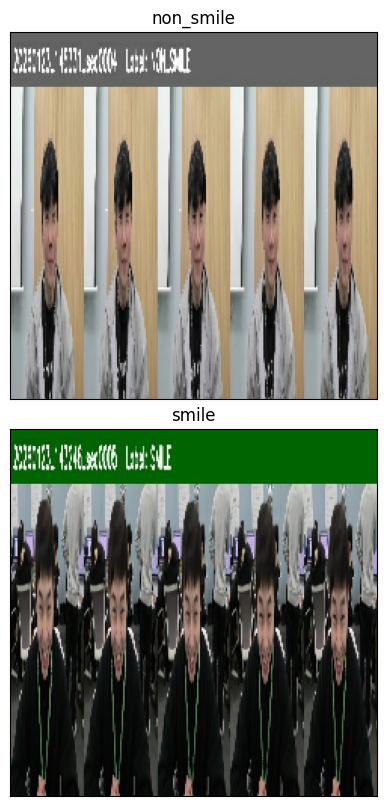

In [8]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8,8),
    subplot_kw={'xticks': [], 'yticks': []}
)

for i, class_idx in enumerate(sorted(class_images.keys())):
    axes[i].imshow(class_images[class_idx].astype("uint8"))
    axes[i].set_title(class_names[class_idx], fontsize=12)

plt.tight_layout(pad=0.5)
plt.show()

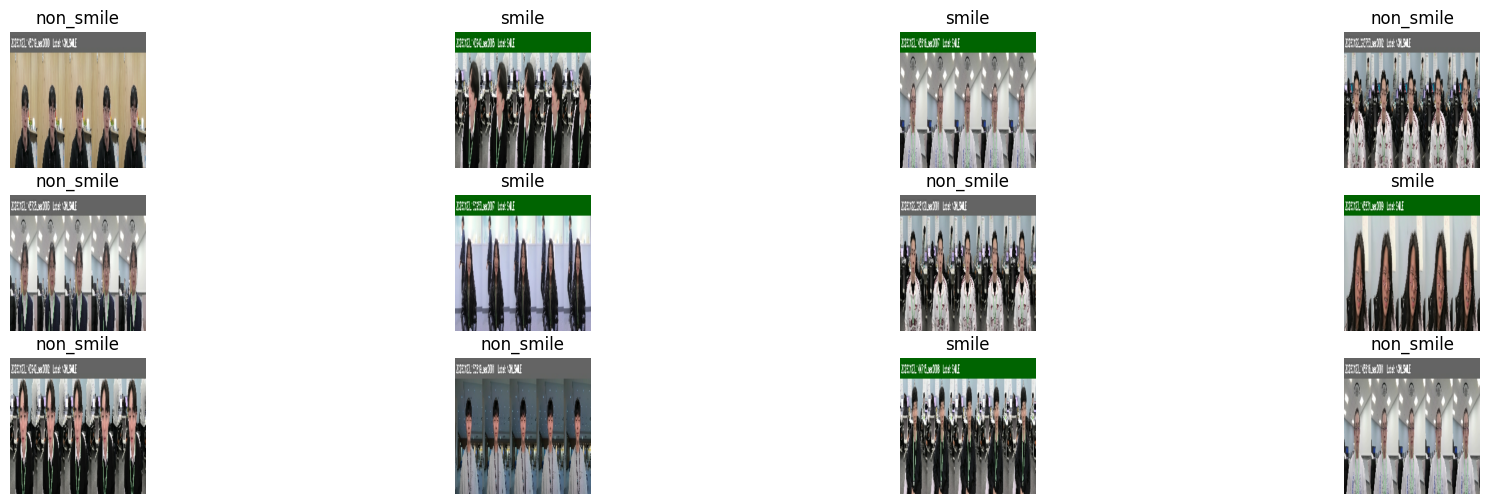

In [9]:
plt.figure(figsize=(22,6))
for image_batch, label_batch in dataset.take(1):

    num_images = min(12, len(image_batch)) 
    
    for i in range(num_images):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])   
        plt.axis('off')

In [10]:
def get_dataset_partitions_tf(
    ds,
    train_split=0.6,
    val_split=0.2,
    test_split=0.2,
    shuffle=True,
    shuffle_size=1000
):
    ds = ds.shuffle(shuffle_size, seed=42) if shuffle else ds

    ds_size = tf.data.experimental.cardinality(ds).numpy()

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [12]:
preprocess = tf.keras.applications.mobilenet_v2.preprocess_input

train_ds = train_ds.map(lambda x, y: (preprocess(x), y))
val_ds   = val_ds.map(lambda x, y: (preprocess(x), y))
test_ds  = test_ds.map(lambda x, y: (preprocess(x), y))

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [14]:
def augment(images, labels):
    return data_augmentation(images, training=True), labels

train_ds = train_ds.map(
    augment,
    num_parallel_calls=tf.data.AUTOTUNE
)

In [15]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.prefetch(tf.data.AUTOTUNE)


In [16]:
for images, _ in dataset.take(1):
    CHANNELS = images.shape[-1]

input_shape = (*IMAGE_SIZE, CHANNELS)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

for layer in base_model.layers[-20:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True


model = tf.keras.Sequential([
    layers.Input(shape=input_shape),
    base_model,

    layers.GlobalAveragePooling2D(),

    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),

    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(1, activation='sigmoid')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,608,577 (9.95 MB)

 Trainable params: 2,537,281 (9.68 MB)

 Non-trainable params: 71,296 (278.50 KB)

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-6),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [19]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_auc',
            patience=5,
            mode='max',
            restore_best_weights=True
        )
    ]
)

Epoch 1/20


I0000 00:00:1769457201.711793     131 service.cc:152] XLA service 0x7c15c0004120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769457201.711856     131 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1769457204.099114     131 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-26 19:53:35.157191: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-26 19:53:35.354628: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1769457223.306933     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proc

4/4 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - auc: 0.4910 - loss: 0.9056 - precision: 0.4567 - recall: 0.5983 - val_auc: 0.5188 - val_loss: 0.6863 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - auc: 0.5709 - loss: 0.7632 - precision: 0.5522 - recall: 0.6353 - val_auc: 0.4824 - val_loss: 0.7662 - val_precision: 0.4815 - val_recall: 0.7647
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - auc: 0.6647 - loss: 0.7322 - precision: 0.5491 - recall: 0.8151 - val_auc: 0.5486 - val_loss: 0.7777 - val_precision: 0.4333 - val_recall: 1.0000
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - auc: 0.5743 - loss: 0.7457 - precision: 0.5596 - recall: 0.7158 - val_auc: 0.4028 - val_loss: 0.7532 - val_precision: 0.5185 - val_recall: 0.7778
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - auc: 0.5439 - loss: 0.8509 - precision: 0.5471 - recall: 0.6786 - val_auc: 0.4937 - val_loss: 0.6839 - val_precision: 0.6207 - val_recall: 0.9000
Epoch 6/20
4/4 ━━━━━━━━━━

In [20]:
results = model.evaluate(test_ds, return_dict=True)

print("\nTest Set Evaluation")
print("=" * 40)
for metric, value in results.items():
    print(f"{metric.capitalize():<15}: {value:.4f}")
print("=" * 40)

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - auc: 0.3781 - loss: 0.7586 - precision: 0.4586 - recall: 0.6938  

Test Set Evaluation
Auc            : 0.3705
Loss           : 0.7778
Precision      : 0.4340
Recall         : 0.6765


In [21]:
def plot_training_history(history):
    history = history.history
    epochs = range(1, len(history['loss']) + 1)

    plt.figure(figsize=(14, 5))

    # AUC
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['auc'], label='Train AUC', marker='o')
    plt.plot(epochs, history['val_auc'], label='Val AUC', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('Training vs Validation AUC')
    plt.legend()
    plt.grid(alpha=0.3)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Val Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary
    best_epoch = history['val_auc'].index(max(history['val_auc'])) + 1

    print("\nTraining Summary")
    print("=" * 40)
    print(f"Epochs trained        : {len(epochs)}")
    print(f"Best Val AUC          : {max(history['val_auc']):.4f}")
    print(f"Best Epoch            : {best_epoch}")
    print(f"Final Train AUC       : {history['auc'][-1]:.4f}")
    print(f"Final Val AUC         : {history['val_auc'][-1]:.4f}")
    print(f"Final Train Loss      : {history['loss'][-1]:.4f}")
    print(f"Final Val Loss        : {history['val_loss'][-1]:.4f}")
    print("=" * 40)


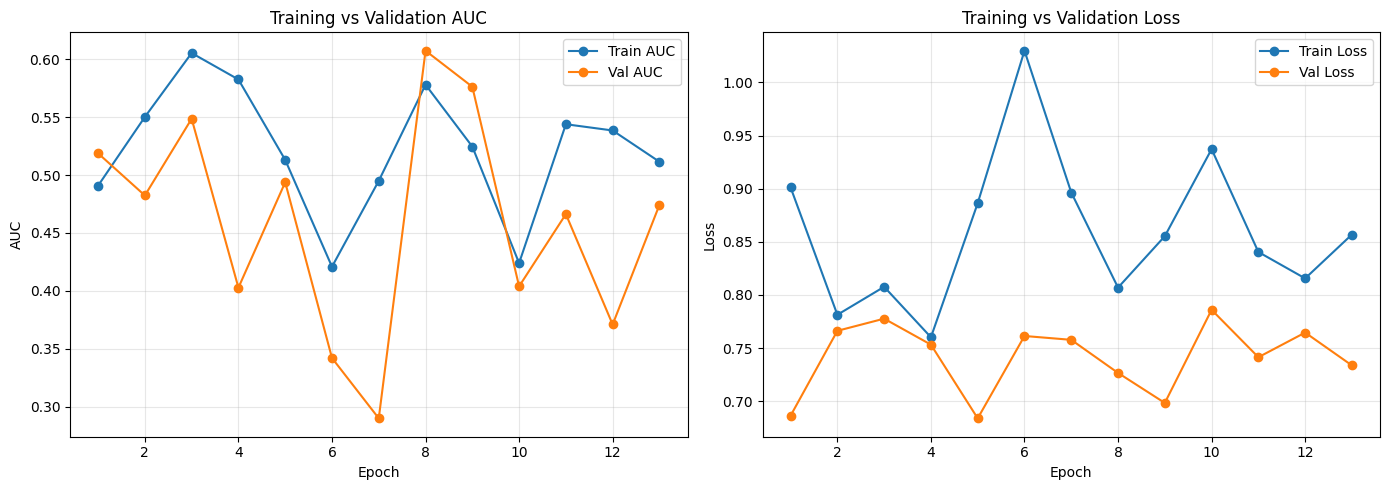


Training Summary
Epochs trained        : 13
Best Val AUC          : 0.6073
Best Epoch            : 8
Final Train AUC       : 0.5115
Final Val AUC         : 0.4742
Final Train Loss      : 0.8569
Final Val Loss        : 0.7337


In [22]:
plot_training_history(history)